In [2]:
%matplotlib inline

In [3]:
import time
import numpy as np
from sklearn.datasets.samples_generator import make_blobs
from sklearn.datasets import make_sparse_uncorrelated
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import LSHForest
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix
import neighbors as kneighbors
import random

from scipy.sparse import dok_matrix
from scipy.sparse import rand
from scipy.sparse import vstack

def create_dataset(seed=None,
                   number_of_centroids=None,
                   number_of_instances=None,
                   number_of_features=None,
                   size_of_dataset=None,
                   density=None,
                   fraction_of_density=None
                   ):
    dataset_neighborhood_list = []
    number_of_swapping_elements = int(number_of_features * density * fraction_of_density)
    y = []
    random_local = random.randint
    number_of_features_density = int(number_of_features*density)-1
    for k in xrange(number_of_centroids):
        dataset_neighbor = rand(1, number_of_features, density=density, format='lil', random_state=seed*k)
        nonzero_elements =  dataset_neighbor.nonzero()[1]
        for i in xrange(size_of_dataset):
            neighbor = dataset_neighbor.copy()
            # random.seed(seed*k)
            for j in xrange(number_of_swapping_elements):
                index = random_local(0, number_of_features_density)
                index_swap = random_local(0, number_of_features-1)
                neighbor[0, nonzero_elements[index]] = 0
                neighbor[0, index_swap] = 1
            dataset_neighborhood_list.append(neighbor)
        y.append(k)

    dataset_neighborhood = vstack(dataset_neighborhood_list)

    size_of_noise = number_of_instances-(number_of_centroids*size_of_dataset)
    if size_of_noise > 0:
            dataset_noise = rand(size_of_noise, number_of_features, format='lil', density=density, random_state=seed*seed)
            dataset = vstack([dataset_neighborhood, dataset_noise])
    else:
        dataset = vstack([dataset_neighborhood])
    random_value_generator = random.randint

    # add classes for noisy data
    for i in range(0, size_of_noise):
        y.append(random_value_generator(0, number_of_centroids))

    return csr_matrix(dataset), y

def create_dataset_fixed_nonzero(seed=None,
                   number_of_centroids=None,
                   number_of_instances=None,
                   number_of_features=None,
                   size_of_dataset=None,
                   non_zero_elements=None,
                   fraction_of_density=None):
    
    if (non_zero_elements > number_of_features):
        print "More non-zero elements than features!"
        return
    density = non_zero_elements / float(number_of_features)
    print "Desity:" , density
    dataset_neighborhood_list = []
    number_of_swapping_elements = int(non_zero_elements * fraction_of_density)
    y = []
    random_local = random.randint
    
    for k in xrange(number_of_centroids):
        dataset_neighbor = rand(1, number_of_features, density=density, format='lil', random_state=seed*k)
        nonzero_elements =  dataset_neighbor.nonzero()[1]
        for i in xrange(size_of_dataset):
            neighbor = dataset_neighbor.copy()
            # random.seed(seed*k)
            for j in xrange(number_of_swapping_elements):
                index = random_local(0, non_zero_elements-1)
                index_swap = random_local(0, number_of_features-1)
                neighbor[0, nonzero_elements[index]] = 0
                neighbor[0, index_swap] = 1
            dataset_neighborhood_list.append(neighbor)
        y.append(k)

    dataset_neighborhood = vstack(dataset_neighborhood_list)

    size_of_noise = number_of_instances-(number_of_centroids*size_of_dataset)
    if size_of_noise > 0:
            dataset_noise = rand(size_of_noise, number_of_features, format='lil', density=density, random_state=seed*seed)
            dataset = vstack([dataset_neighborhood, dataset_noise])
    else:
        dataset = vstack([dataset_neighborhood])
    random_value_generator = random.randint

    # add classes for noisy data
    for i in range(0, size_of_noise):
        y.append(random_value_generator(0, number_of_centroids))

    return csr_matrix(dataset), y


In [4]:
def measure_peformance( dataset, y, n_neighbors_sklearn = 5, n_neighbors_minHash = 5, number_of_instances = [1000, 10000],
    number_of_features = [10000,  100000], allNeighbors=False):
#     n_neighbors_sklearn = 5
#     n_neighbors_minHash = 5

    
    time_fit_sklearn = []
    time_fit_minHash = []
    time_fit_lshf = []
    time_query_time_50_1_sklearn = []
    time_query_time_50_1_minHash_exact = []
    time_query_time_50_1_minHash_approx = []
    time_query_time_50_1_lshf = []

    time_query_time_1_50_sklearn = []
    time_query_time_1_50_minHash_exact = []
    time_query_time_1_50_minHash_approx = []
    time_query_time_1_50_lshf = []
    
    accuracy_1_50_lshf = []
    accuracy_1_50_minHash_exact = []
    accuracy_1_50_minHash_aprox = []
    
    
#     seed = 6
    centroids = 8
    size_of_datasets = 7
#     number_of_instances = [1000, 10000]
#     number_of_features = [10000,  100000]
#     density = 0.01
#     fraction_of_density = 0.2

    size_of_query = 50
    for dataset_ in dataset:
        
        nearest_neighbor_sklearn = NearestNeighbors(n_neighbors = n_neighbors_sklearn)
        nearest_neighbor_minHash = kneighbors.MinHashNearestNeighbors(n_neighbors = n_neighbors_minHash)
        nearest_neighbor_lshf = LSHForest(n_estimators=20, n_candidates=200, n_neighbors=7)
        
        time_start = time.time()
        nearest_neighbor_sklearn.fit(dataset_)
        time_end = time.time()
        time_fit_sklearn.append(time_end - time_start)

        time_start = time.time()
        nearest_neighbor_minHash.fit(dataset_)
        time_end = time.time()
        time_fit_minHash.append(time_end - time_start)

        time_start = time.time()
        nearest_neighbor_lshf.fit(dataset_)
        time_end = time.time()
        time_fit_lshf.append(time_end - time_start)
        
        if allNeighbors:
            query_ids = []
            for i in range(size_of_query):
                query_ids.append(random.randint(0, centroids * size_of_datasets))
            print "Query ids: ", query_ids
    #         print "Dataset: ", dataset_
            print "Shape: ", dataset_.shape
            query = dataset_[query_ids]
        else:
            query = None

        time_start = time.time()
        n_neighbors_sklearn_1_50 = nearest_neighbor_sklearn.kneighbors(query, return_distance=False)
        time_end = time.time()
        time_query_time_1_50_sklearn.append(time_end - time_start)

        time_start = time.time()
        n_neighbors_minHash_exact_1_50 = nearest_neighbor_minHash.kneighbors(query, algorithm="exact", return_distance=False)
        time_end = time.time()
        time_query_time_1_50_minHash_exact.append(time_end - time_start)
        

        time_start = time.time()
        n_neighbors_minHash_approx_1_50 = nearest_neighbor_minHash.kneighbors(query, algorithm="approximate",return_distance=False)
        time_end = time.time()
        time_query_time_1_50_minHash_approx.append(time_end - time_start)

        time_start = time.time()
        n_neighbors_lshf_1_50 = nearest_neighbor_lshf.kneighbors(query,return_distance=False)
        time_end = time.time()
        time_query_time_1_50_lshf.append(time_end - time_start)

        
        accuracy_1_50_lshf.append(np.in1d(n_neighbors_lshf_1_50, n_neighbors_sklearn_1_50).mean())
        accuracy_1_50_minHash_exact.append(np.in1d(n_neighbors_minHash_exact_1_50, n_neighbors_sklearn_1_50).mean())
        accuracy_1_50_minHash_aprox.append(np.in1d(n_neighbors_minHash_approx_1_50, n_neighbors_sklearn_1_50).mean())
    
    
        time_query_time_50_1_sklearn_loc = []
        time_query_time_50_1_sklearn_loc = []
        for i in range(size_of_query):
            time_start = time.time()
            nearest_neighbor_sklearn.kneighbors(query[i],return_distance=False)
            time_end = time.time()
            time_query_time_50_1_sklearn_loc.append(time_end - time_start)
        time_query_time_50_1_sklearn.append(np.sum(time_query_time_50_1_sklearn_loc))
        time_query_time_50_1_minHash_exact_loc = []
        for i in range(size_of_query):
            time_start = time.time()
            nearest_neighbor_minHash.kneighbors(query[i], algorithm="exact",return_distance=False)
            time_end = time.time()
            time_query_time_50_1_minHash_exact_loc.append(time_end - time_start)
        time_query_time_50_1_minHash_exact.append(np.sum(time_query_time_50_1_minHash_exact_loc))
        time_query_time_50_1_minHash_approx_loc = []
        for i in range(size_of_query):
            time_start = time.time()
            nearest_neighbor_minHash.kneighbors(query[i], algorithm="approximate",return_distance=False)
            time_end = time.time()
            time_query_time_50_1_minHash_approx_loc.append(time_end - time_start)
        time_query_time_50_1_minHash_approx.append(np.sum(time_query_time_50_1_minHash_approx_loc))
        time_query_time_50_1_lshf_loc = []
        for i in range(size_of_query):
            time_start = time.time()
            nearest_neighbor_lshf.kneighbors(query[i], return_distance=False)
            time_end = time.time()
            time_query_time_50_1_lshf_loc.append(time_end - time_start)
        time_query_time_50_1_lshf.append(np.sum(time_query_time_50_1_lshf_loc))

    # for i in xrange(len(time_fit_sklearn)):

    #     print "(50_1) Number of queries to be better than sklearn: ", (time_fit_minHash[i])/ (time_query_time_50_1_sklearn[i] -time_query_time_50_1_minHash_exact[i])
    #     print "(1_50) Number of queries to be better than sklearn: ", (time_fit_minHash[i]) /(time_query_time_1_50_sklearn[i] -time_query_time_1_50_minHash_exact[i])
    plt.figure(figsize=(30,11))
    N = len(number_of_instances) * len(number_of_features)

    ind = np.arange(N)    # the x locations for the groups
    bar_width = 0.05       # the width of the bars: can also be len(x) sequence
    #"r", "b", "g", "c", "m", "y", "k", "w"
    p1 = plt.bar(ind, time_fit_sklearn,   bar_width, color='r', label = "fit_sklearn")
    p2 = plt.bar(ind + bar_width, time_fit_minHash,   bar_width, color='g', label="fit_minHash")
    p10 = plt.bar(ind + 2*bar_width, time_fit_lshf,   bar_width, color='w', label="fit_lshf")
    p3 = plt.bar(ind + 3*bar_width, time_query_time_50_1_sklearn,   bar_width, color='r', label="query_sklearn_50_1")
    p4 = plt.bar(ind + 4*bar_width, time_query_time_50_1_minHash_exact,   bar_width, color='b', label="query_minHash_exact_50_1")
    p5 = plt.bar(ind + 5*bar_width, time_query_time_50_1_minHash_approx,   bar_width, color='m',label="query_minHash_approx_50_1")
    p11 = plt.bar(ind + 6*bar_width, time_query_time_50_1_lshf,   bar_width, color='w',label="query_lshf_50_1")
    p6 = plt.bar(ind + 7*bar_width, time_query_time_1_50_sklearn,   bar_width, color='r',label="query_sklearn_1_50")
    p7 = plt.bar(ind + 8*bar_width, time_query_time_1_50_minHash_exact,   bar_width, color='b',label="query_minHash_exact_1_50")
    p8 = plt.bar(ind + 9*bar_width, time_query_time_1_50_minHash_approx,   bar_width, color='m',label="query_minHash_approx_1_50")
    p9 = plt.bar(ind + 10*bar_width, time_query_time_1_50_lshf,   bar_width, color='w',label="query_lshf_1_50")


    plt.ylabel('Time')
    title = 'Time for fitting and query for different datasets; density: '
    title += str(density)
    plt.title(title)
    plt.xticks(ind + bar_width, ("1000 / 10000", "1000 / 100000", "10000 / 10000","10000 / 100000"))
    plt.yticks(np.arange(0,11,0.5))

    # plt.legend( (p1[0], p2[0], p3[0], p4[0], p5[0], p6[0], p7[0], p8[0]), 
    #            ('fit_sklearn', 'fit_minHash', 'query_sklearn_50_1','query_minHash_exact_50_1',
    #                              'query_minHash_50_1',
    #                             'query_sklearn_1_50','query_minHash_exact_1_50','query_minHash_approx_1_50') )
    plt.legend(loc='upper left', fontsize='small')
    plt.show()
    
    print "Accuracy lshf:", np.mean(accuracy_1_50_lshf)
    print "Accuracy minHash_exact:", np.mean(accuracy_1_50_minHash_exact)
    print "Accuracy minHash_appox:", np.mean(accuracy_1_50_minHash_aprox)
    for i in xrange(len(time_fit_sklearn)):
        print "Fitting time sklearn: ", time_fit_sklearn[i]
        print "Fitting time minHash: ", time_fit_minHash[i]
        print "Fitting time lshf: ", time_fit_lshf[i]

In [5]:
seed = 6
centroids = 8
size_of_datasets = 7
number_of_instances = [1000]
number_of_features = [10000]
density = 0.01
fraction_of_density = 0.2
n_neighbors_sklearn = 5
n_neighbors_minHash = 5


datasets: 4
size (1000, 10000)
size (1000, 100000)
size (10000, 10000)
size (10000, 100000)
Query ids:  [22, 53, 30, 10, 12, 7, 18, 14, 24, 0, 10, 0, 54, 36, 28, 10, 2, 18, 0, 0, 3, 37, 27, 54, 55, 25, 14, 54, 25, 42, 54, 38, 26, 38, 16, 47, 22, 26, 19, 8, 36, 18, 27, 52, 34, 43, 2, 4, 56, 43]
Shape:  (1000, 10000)
Query ids:  [38, 0, 34, 51, 54, 38, 13, 51, 52, 26, 18, 23, 1, 44, 39, 19, 24, 48, 1, 6, 53, 6, 15, 32, 55, 20, 54, 41, 41, 37, 17, 28, 53, 39, 4, 40, 44, 22, 49, 46, 12, 25, 34, 12, 39, 27, 44, 44, 41, 13]
Shape:  (1000, 100000)
Query ids:  [41, 19, 10, 46, 24, 53, 16, 2, 32, 36, 9, 34, 35, 9, 14, 14, 26, 40, 44, 28, 50, 35, 18, 28, 42, 40, 24, 16, 5, 14, 50, 11, 4, 18, 18, 37, 6, 55, 2, 53, 55, 20, 18, 44, 2, 40, 27, 30, 39, 5]
Shape:  (10000, 10000)
Query ids:  [41, 47, 42, 46, 49, 8, 48, 12, 29, 25, 52, 56, 14, 30, 22, 35, 54, 14, 1, 0, 50, 9, 10, 55, 23, 43, 36, 39, 7, 19, 11, 43, 39, 28, 17, 14, 15, 10, 30, 23, 53, 10, 13, 9, 17, 51, 3, 17, 51, 50]
Shape:  (10000, 1000

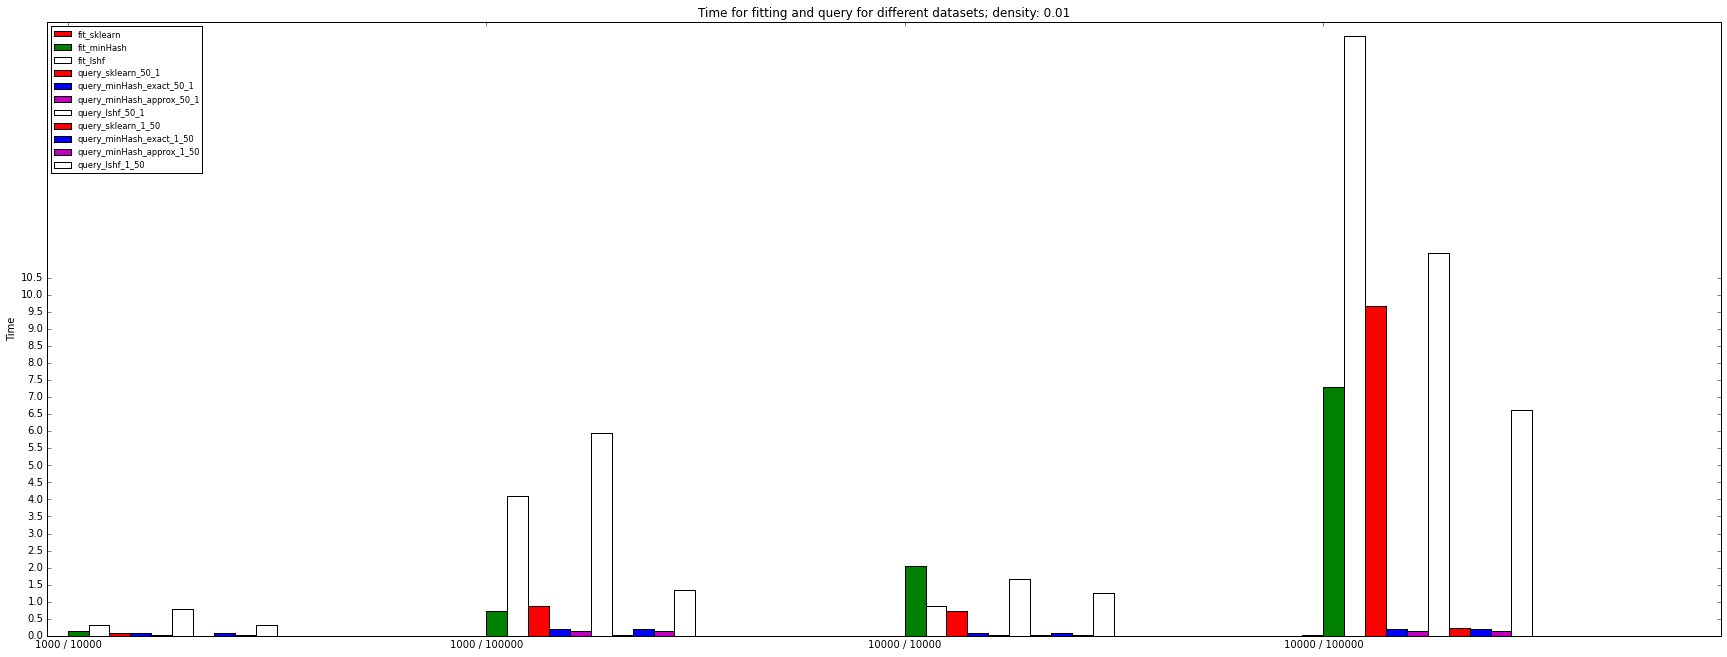

Accuracy lshf: 0.841428571429
Accuracy minHash_exact: 0.938
Accuracy minHash_appox: 0.927


In [21]:

dataset_array = []
for instances in number_of_instances:
    for features in number_of_features:
        dataset, y = create_dataset(seed=seed, number_of_centroids=centroids, number_of_instances=instances,
                                         number_of_features=features,density = density,
                                         fraction_of_density=fraction_of_density, size_of_dataset = size_of_datasets)
        dataset_array.append(dataset)

print "datasets:", len(dataset_array)
print "size", dataset_array[0].shape
print "size", dataset_array[1].shape
print "size", dataset_array[2].shape
print "size", dataset_array[3].shape
measure_peformance(dataset_array, y, n_neighbors_sklearn, n_neighbors_minHash, number_of_instances, number_of_features)


Desity: 0.01
Query ids:  [7, 2, 6, 55, 29, 48, 47, 12, 46, 51, 12, 51, 19, 33, 47, 56, 48, 46, 55, 36, 31, 44, 3, 14, 9, 34, 25, 51, 55, 49, 12, 47, 19, 27, 36, 40, 47, 34, 14, 36, 29, 1, 37, 29, 45, 52, 3, 46, 34, 48]
Shape:  (100, 1000)


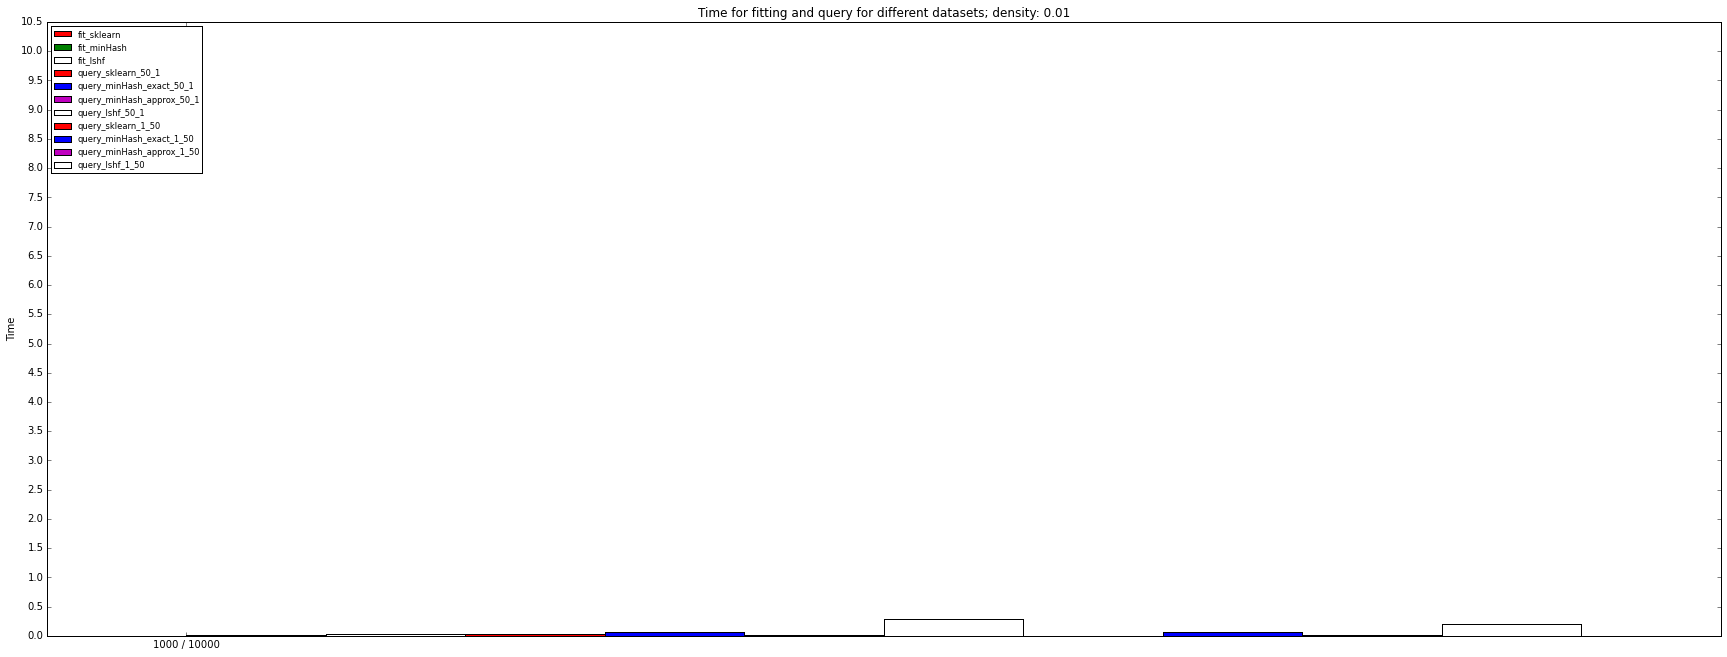

Accuracy lshf: 0.911428571429
Accuracy minHash_exact: 0.94
Accuracy minHash_appox: 0.92
Fitting time sklearn:  0.000131130218506
Fitting time minHash:  0.00870609283447
Fitting time lshf:  0.0350980758667


In [19]:
number_of_instances = [100]
number_of_features = [int(1e3)]#, int(1e4), int(1e5)]
dataset_array = []
for instances in number_of_instances:
    for features in number_of_features:
        dataset_fixed, y = create_dataset_fixed_nonzero(seed=5,
                   number_of_centroids=7,
                   number_of_instances=instances,
                   number_of_features=features,
                   size_of_dataset=8,
                   non_zero_elements=10,
                   fraction_of_density=0.2)
        dataset_array.append(dataset_fixed)
measure_peformance(dataset_array, y, n_neighbors_sklearn, n_neighbors_minHash, number_of_instances, number_of_features)


In [6]:
from eden.converter.graph.gspan import gspan_to_eden
from eden.graph import Vectorizer
graphs = gspan_to_eden( 'http://www.bioinf.uni-freiburg.de/~costa/bursi.gspan' )
vectorizer = Vectorizer( r=2,d=5 )
X = vectorizer.transform( graphs )
y = None
print "Shape", X.shape
print "nnz:", X.getnnz()
print "sparsity: ", X.getnnz() / float(X.shape[1])

Shape (4337, 1048577)
nnz: 726907
sparsity:  0.693231875198


In [ ]:
nearest_neighbor_sklearn = NearestNeighbors(n_neighbors = n_neighbors_sklearn)
nearest_neighbor_minHash = kneighbors.MinHashNearestNeighbors(n_neighbors = n_neighbors_minHash)
nearest_neighbor_lshf = LSHForest(n_estimators=20, n_candidates=200, n_neighbors=n_neighbors_minHash)

time_start = time.time()
nearest_neighbor_sklearn.fit(X)
time_end = time.time()
time_fit_sklearn = time_end - time_start

time_start = time.time()
nearest_neighbor_minHash.fit(X)
# print nearest_neighbor_minHash._inverseIndex._inverse_index
time_end = time.time()
time_fit_minHash = time_end - time_start

time_start = time.time()
nearest_neighbor_lshf.fit(X)
time_end = time.time()
time_fit_lshf = time_end - time_start

time_start = time.time()
n_neighbors_sklearn_1_50 = nearest_neighbor_sklearn.kneighbors(return_distance=False)
time_end = time.time()
time_query_time_1_50_sklearn = time_end - time_start

time_start = time.time()
n_neighbors_minHash_exact_1_50 = nearest_neighbor_minHash.kneighbors(algorithm="exact", return_distance=False)
time_end = time.time()
time_query_time_1_50_minHash_exact = time_end - time_start


time_start = time.time()
n_neighbors_minHash_approx_1_50 = nearest_neighbor_minHash.kneighbors(algorithm="approximate",return_distance=False)
# print n_neighbors_minHash_approx_1_50
time_end = time.time()
time_query_time_1_50_minHash_approx = time_end - time_start

time_start = time.time()
n_neighbors_lshf_1_50 = nearest_neighbor_lshf.kneighbors(X,return_distance=False)
time_end = time.time()
time_query_time_1_50_lshf = time_end - time_start


accuracy_1_50_lshf = np.in1d(n_neighbors_lshf_1_50, n_neighbors_sklearn_1_50).mean()
accuracy_1_50_minHash_exact = np.in1d(n_neighbors_minHash_exact_1_50, n_neighbors_sklearn_1_50).mean()
accuracy_1_50_minHash_approx = np.in1d(n_neighbors_minHash_approx_1_50, n_neighbors_sklearn_1_50).mean()



In [ ]:
# plt.figure(figsize=(10,5))
N = 1

ind = np.arange(N)    # the x locations for the groups
bar_width = 0.05       # the width of the bars: can also be len(x) sequence
#"r", "b", "g", "c", "m", "y", "k", "w"
p1 = plt.bar(ind, time_fit_sklearn,   bar_width, color='r', label = "fit_sklearn")
p2 = plt.bar(ind + bar_width, time_fit_minHash,   bar_width, color='g', label="fit_minHash")
p3 = plt.bar(ind + 2*bar_width, time_fit_lshf,   bar_width, color='w', label="fit_lshf")

p4 = plt.bar(ind + 3*bar_width, time_query_time_1_50_sklearn,   bar_width, color='r',label="query_sklearn")
p5 = plt.bar(ind + 4*bar_width, time_query_time_1_50_minHash_exact,   bar_width, color='g',label="query_minHash_exact")
p6 = plt.bar(ind + 5*bar_width, time_query_time_1_50_minHash_approx,   bar_width, color='g',label="query_minHash_approx")
p7 = plt.bar(ind + 6*bar_width, time_query_time_1_50_lshf,   bar_width, color='w',label="query_lsh")


plt.ylabel('Time')
title = 'bursi.gspan dataset'
plt.title(title)
plt.xticks(ind + bar_width, ())
# plt.yticks(np.arange(0,10,1))

# plt.legend( (p1[0], p2[0], p3[0], p4[0], p5[0], p6[0], p7[0], p8[0]), 
#            ('fit_sklearn', 'fit_minHash', 'query_sklearn_50_1','query_minHash_exact_50_1',
#                              'query_minHash_50_1',
#                             'query_sklearn_1_50','query_minHash_exact_1_50','query_minHash_approx_1_50') )
plt.legend(loc='upper left', fontsize='small')
plt.show()

print "Accuracy lshf: ", accuracy_1_50_lshf
print "Accuracy minHash_exact: ", accuracy_1_50_minHash_exact
print "Accuracy minHash_approx: ", accuracy_1_50_minHash_approx